In [4]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.io import FortranFile
from cobaya.model import get_model
import yaml
import os
from getdist import plots, MCSamples
from cobaya.conventions import Const, packages_path_input
from scipy.optimize import minimize
from scipy.optimize import differential_evolution

In [9]:
path_GLM_data = '../GLM_data/'

In [10]:

getdist_settings = {
    'smooth_scale_1D': 0.3,
    'smooth_scale_2D': 0.4,
    'boundary_correction_order': 1,
    'mult_bias_correction_order': 1,
    }


# Planck HL

In [11]:
yaml_path = "../chains/01p2_LCDM_CMB_PlanckTTTEEE.input.yaml"

# define the path to the YAML parameters file:
yaml_params = yaml_path #os.path.join(chains_dir, name + '.input.yaml')
# load the parameters from the YAML file:
with open(yaml_params, 'r') as f:
    params_dict = yaml.safe_load(f)
# remove the 'path' key from the 'camb' dictionary if it exists:
if 'path' in params_dict.get('theory', {}).get('camb', {}):
    del params_dict['theory']['camb']['path']
if 'recombination_model' in params_dict.get('theory', {}).get('camb', {}).get('extra_args', {}):
    del params_dict['theory']['camb']['extra_args']['recombination_model']
if 'max_zrei'in params_dict.get('theory', {}).get('camb', {}).get('extra_args', {}):
    del params_dict['theory']['camb']['extra_args']['max_zrei']
    print('Removed "max_zrei" from the "camb" extra_args in the YAML parameters file.')
# build the model:
model = get_model(params_dict)

Removed "max_zrei" from the "camb" extra_args in the YAML parameters file.
[model] *WARNING* Ignored blocks/options: ['sampler', 'output']
[camb] `camb` module loaded successfully from /home/afarina/anaconda3/envs/nbase/lib/python3.12/site-packages/camb


In [ ]:
chains_dir = os.path.join('../chains/')

# import chain
from cobaya import load_samples

name = '01p2_LCDM_CMB_PlanckTTTEEE'
chain = load_samples(os.path.join(chains_dir, name), skip=0.3, to_getdist=True)
chain.label = name
chain.root = os.path.join(chains_dir, name)
chain.updateSettings(getdist_settings)
chain.updateBaseStatistics()
chain.getConvergeTests()
print(chain.label+': R =', round(chain.GelmanRubin, 4))


BestFit = chain.getBestFit()
BestFitDict = BestFit.getParamDict()

params = model.parameterization.sampled_params()
for p in params.keys():
    params[p] = BestFitDict[p]  # Set the best fit values for all parameters

params_values = np.array([params[p] for p in params.keys()])
params_names = np.array(list(params.keys()))



[samplecollection] Loaded 4123 sample points from '../chains/01p2_LCDM_CMB_PlanckTTTEEE.1.txt'
[samplecollection] Loaded 4281 sample points from '../chains/01p2_LCDM_CMB_PlanckTTTEEE.2.txt'


[samplecollection] Loaded 4116 sample points from '../chains/01p2_LCDM_CMB_PlanckTTTEEE.3.txt'
[samplecollection] Loaded 4117 sample points from '../chains/01p2_LCDM_CMB_PlanckTTTEEE.4.txt'
01p2_LCDM_CMB_PlanckTTTEEE: R = 0.0079


### Obtaining Covariance matrix 

In [ ]:
# Load the covariance matrix from the data
cov_data =  np.load(path_GLM_data + "cov_data_Planck_hl.npy")
# Load the posterior covariance matrix from the file in the chains
# cov_posterior = np.loadtxt('../chains/LCDM/01p1_LCDM_BAO_DESIDR2.covmat')
cov_posterior = np.loadtxt('../chains/01p2_LCDM_CMB_PlanckTTTEEE.covmat')


# import chain for the prior and then extrPlanck_hl the covariance matrix
chains_dir = os.path.join('../chains')
from cobaya import load_samples
name = '01p2_LCDM_CMB_PlanckTTTEEE.prior'
chain_prior = load_samples(os.path.join(chains_dir, name), skip=0.3, to_getdist=True)
chain_prior.label = name
chain_prior.root = os.path.join(chains_dir, name)
chain_prior.updateSettings(getdist_settings)
chain_prior.updateBaseStatistics()
chain_prior.getConvergeTests()
print(chain_prior.label+': R =', round(chain_prior.GelmanRubin, 4))
# ExtrPlanck_hl the parameter names.
param_names = list(params.keys())

cov_prior = chain.cov(pars=param_names)


[samplecollection] Loaded 350 sample points from '../chains/01p2_LCDM_CMB_PlanckTTTEEE.prior.1.txt'
[samplecollection] Loaded 350 sample points from '../chains/01p2_LCDM_CMB_PlanckTTTEEE.prior.2.txt'
[samplecollection] Loaded 350 sample points from '../chains/01p2_LCDM_CMB_PlanckTTTEEE.prior.3.txt'
[samplecollection] Loaded 350 sample points from '../chains/01p2_LCDM_CMB_PlanckTTTEEE.prior.4.txt'


01p2_LCDM_CMB_PlanckTTTEEE.prior: R = 0.0097


## jacobian computation

In [21]:
Planck_hl_datavector = np.load(path_GLM_data + 'Planck_hl_datavector.npy')

In [ ]:
def binning_matrix(ix=0):
    # not used by main likelihood code
    lmax = blmax[used_bins[ix][-1]]
    lmin = blmin[used_bins[ix][0]]
    m = np.zeros((len(used_bins[ix]), lmax - lmin + 1))
    for i in used_bins[ix]:
        m[i, blmin[i] - lmin:blmax[i] + 1 - lmin] = weights[
                                                                blmin[i]:
                                                                blmax[i] + 1]
    return lmin, lmax, m


def get_Planck_hl_model(params):
    model.provider.set_current_input_params(params)
    logposterior = model.loglike(params, return_derived=False)
    Cls = model.provider.get_Cl(ell_fPlanck_hlor=True)
    blmax = model.components[0].blmax
    blmin = model.components[0].blmin

    used_bins = model.components[0].used_bins
    weights = model.components[0].weights

    used_indices = model.components[0].used_indices

    L0 = Cls['ell'][0]

    cl = np.empty(used_indices.shape)
    ix = 0
    for tp, cell in enumerate([Cls['tt'], Cls['te'], Cls['ee']]):
        for i in used_bins[tp]:
            cl[ix] = np.dot(cell[blmin[i] - L0:blmax[i] - L0 + 1],
                            weights[blmin[i]:blmax[i] + 1])
            ix += 1
    cl /= params['A_planck'] ** 2
    return cl

In [23]:
model_pred_bf = get_Planck_hl_model(params)

In [24]:
x_obs = Planck_hl_datavector

In [25]:
# Compute the Jacobian numerically using finite differences on the model predictions.
scale=0.01
jacobian = np.zeros((len(Planck_hl_datavector), len(params)))
for i, p in enumerate(params.keys()):
    param_perturbed_plus = params.copy()  # Create a copy of the parameters
    param_perturbed_minus = params.copy()  # Create a copy of the parameters

    param_perturbed_plus[p] *= 1 + scale  # Perturb the parameter
    param_perturbed_minus[p] *= 1 - scale  # Perturb the parameter

    # model.loglike(param_perturbed_minus, return_derived=False)
    # temp = model.components[0]
    # model_pred_minus = np.array([temp.theory_fun(z,obs) for z,obs in zip(temp.data['z'], temp.data['observable'])]).T[0]
    model_pred_minus = get_Planck_hl_model(param_perturbed_minus)
    model_pred_plus = get_Planck_hl_model(param_perturbed_plus)

    # model.loglike(param_perturbed_plus, return_derived=False)
    # temp = model.components[0]
    # model_pred_plus = np.array([temp.theory_fun(z,obs) for z,obs in zip(temp.data['z'], temp.data['observable'])]).T[0]


    jacobian[:, i] = (model_pred_plus - model_pred_minus) / (param_perturbed_plus[p] - param_perturbed_minus[p]) / 2  # Numerical derivative  

In [26]:
full_rank_ = np.linalg.matrix_rank(jacobian) == np.min(np.shape(jacobian))

print('is the jacobian full rank?', '\n', '\n', full_rank_  )

is the jacobian full rank? 
 
 True


In [27]:
# We need to ensure that the Jacobian is not singular, so we add a small numerical errors to the diagonal if necessary.
if not full_rank_:
    jacobian_fixed = np.copy(jacobian)
    for i in range(len(params.keys())):
        if np.all(jacobian_fixed[:,i]== np.zeros((13))):
            jacobian_fixed[i,i]=10**(-2)
else:
    jacobian_fixed = jacobian


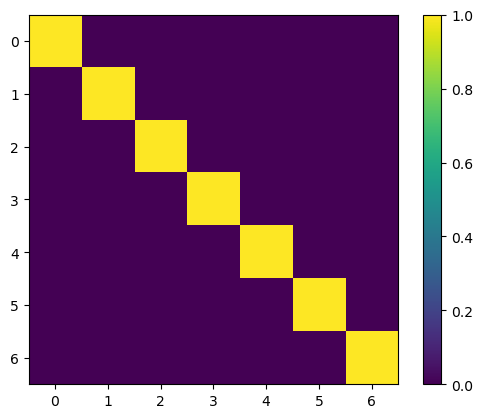

In [28]:
# Computing M_tilde and then making sure that M_tilde @ jacobian_fixed is the identity.
M_tilde = np.linalg.inv(np.transpose(jacobian_fixed) @ np.linalg.inv(cov_data) @ jacobian_fixed) @ jacobian_fixed.T @ np.linalg.inv(cov_data) 

plt.imshow(M_tilde @ jacobian_fixed)
plt.colorbar()

In [29]:
# Now we can compute the maximum likelihood estimate of the parameters using the formula.
theta_ML = np.array(list(params_values)) + cov_posterior @ np.linalg.inv(cov_prior) @ M_tilde @(x_obs-model_pred_bf)

## Computing the estimators

In [30]:
# Here we compute the maximum likelihood estimator Q_ML (the log-likelihood is already normalized so we don't need extra terms in Q_ML) ref : 120
Q_ML = -2*model.loglike(dict(zip(param_names, theta_ML)), return_derived=False)

#probability to exceed the observed value
from scipy.stats import chi2
p_value = chi2.sf(Q_ML,13-6)
p_value

2.0203348636484514e-43

In [31]:
_temp = np.dot(cov_posterior, np.linalg.inv(cov_prior))
# compute Neff from the regularized spectrum of the eigenvalues:
_eigv, _eigvec = np.linalg.eig(_temp)
_eigv[_eigv > 1.] = 1.
_eigv[_eigv < 0.] = 0.
#
_Ntot = len(_eigv)
_Neff = _Ntot - np.real(np.sum(_eigv))
_Neff


0.08986258190244722

In [32]:
# Now we can compute the estimor Q_MAP, which is the log-likelihood at the best fit parameters.ref: 125
Q_MAP = -2*model.loglike(params, return_derived=False)   

from scipy.stats import chi2

#probability to exceed the observed value
p_value = chi2.sf(Q_MAP,13-_Neff)
p_value

6.749379837561033e-39

In [33]:
# Finally, we can compute the prior term Q_prior using ref 134.
Q_prior = -2*(model.loglike(params, return_derived=False)  + model.logpost(params))-6*np.log(2*np.pi)-np.log(np.linalg.det(cov_prior)) 

from scipy.stats import chi2
#probability to exceed the observed value
p_value = chi2.sf(Q_prior,13)
p_value

3.4003524944877584e-96

In [34]:
# Here we compute the bayesian dimensionality
C = np.linalg.inv(np.linalg.inv(cov_posterior)-np.linalg.inv(cov_prior))
CM1 =  np.linalg.inv(cov_posterior)-np.linalg.inv(cov_prior)

d_Bayes = np.trace(CM1 @ cov_posterior @ CM1 @ cov_posterior) + 2*(np.array(list(params.values()))-theta_ML).T @ CM1 @ cov_posterior @ CM1 @ (np.array(list(params.values()))-theta_ML)   

# CMB